Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

Rozdział 16. Modelowanie danych sekwencyjnych za pomocą rekurencyjnych sieci neuronowych (2/2)
========



Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-03 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0
tensorflow_datasets 1.2.0


In [1]:
from IPython.display import Image
%matplotlib inline

## Drugi projekt — modelowanie języka na poziomie znaków w TensorFlow


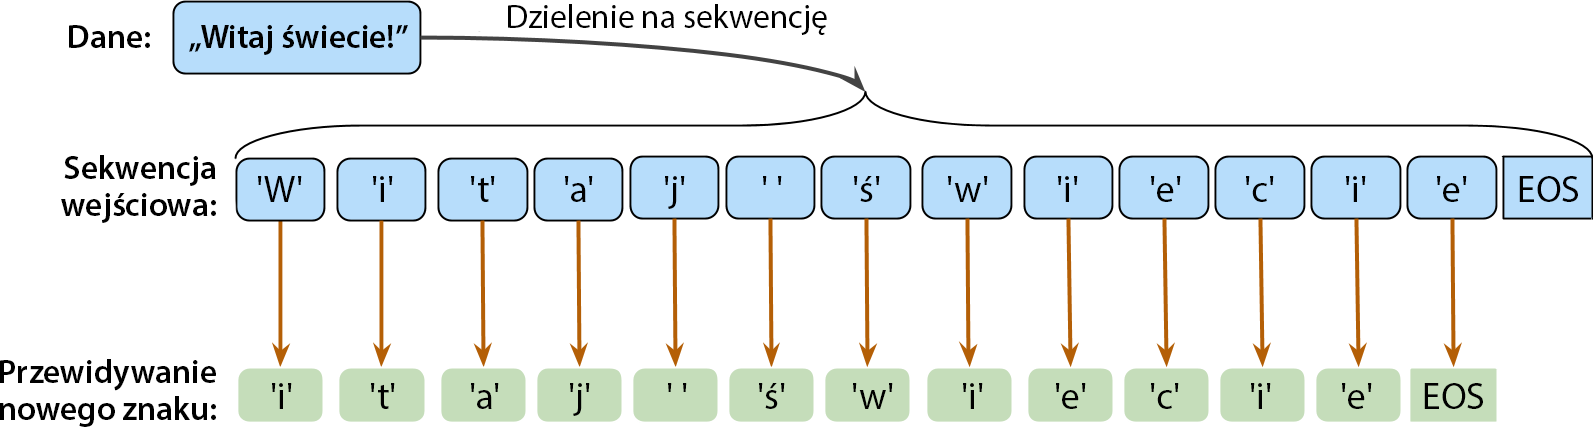

In [2]:
Image(filename='rysunki/16_11.png', width=700)

### Przygotowanie danych

In [4]:
! curl -O http://www.gutenberg.org/files/1268/1268-0.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1144k  100 1144k    0     0  1807k      0 --:--:-- --:--:-- --:--:-- 1807k


In [5]:
import numpy as np


## Wczytanie i wstępne przetwarzanie tekstu
with open('1268-0.txt', 'r') as fp:
    text=fp.read()
    
start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')
print(start_indx, end_indx)

text = text[start_indx:end_indx]
char_set = set(text)
print('Długość całkowita:', len(text))
print('Niepowtarzalne znaki:', len(char_set))

567 1112917
Total Length: 1112350
Unique Characters: 80


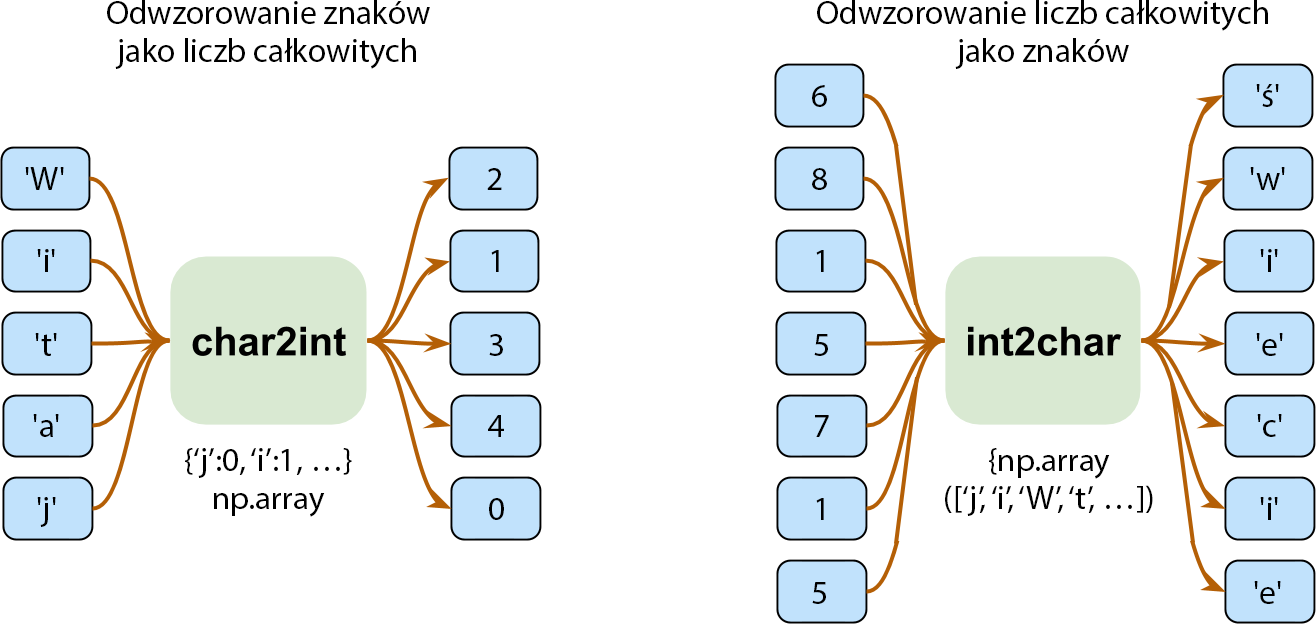

In [3]:
Image(filename='rysunki/16_12.png', width=700)

In [7]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
    dtype=np.int32)

print('Rozmiar zakodowanego tekstu: ', text_encoded.shape)

print(text[:15], '     == Kodowanie ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == Odwrotne   ==> ', ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (1112350,)
THE MYSTERIOUS       == Encoding ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == Reverse  ==>  ISLAND


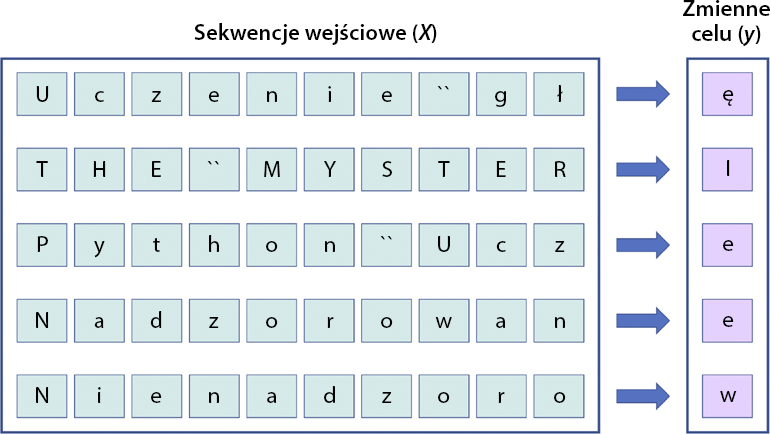

In [4]:
Image(filename='rysunki/16_13.png', width=700)

In [9]:
import tensorflow as tf


ds_text_encoded = tf.data.Dataset.from_tensor_slices(text_encoded)

for ex in ds_text_encoded.take(5):
    print('{} -> {}'.format(ex.numpy(), char_array[ex.numpy()]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


In [10]:
seq_length = 40
chunk_size = seq_length + 1

ds_chunks = ds_text_encoded.batch(chunk_size, drop_remainder=True)

## inspection:
for seq in ds_chunks.take(1):
    input_seq = seq[:seq_length].numpy()
    target = seq[seq_length].numpy()
    print(input_seq, ' -> ', target)
    print(repr(''.join(char_array[input_seq])), 
          ' -> ', repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


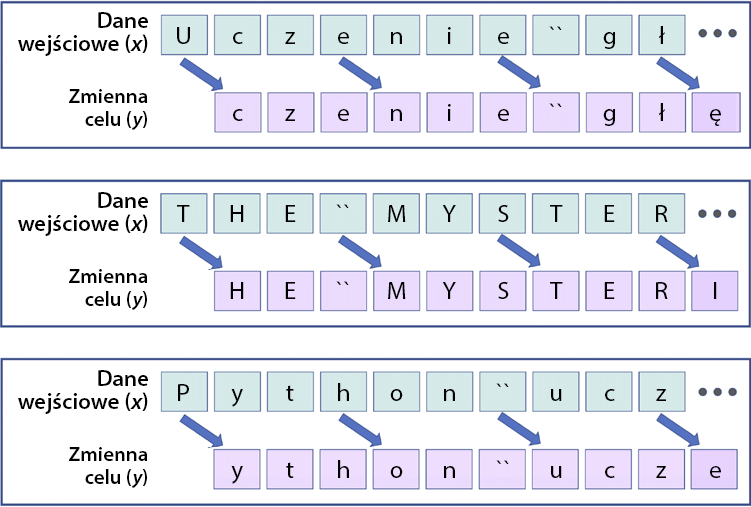

In [5]:
Image(filename='rysunki/16_14.png', width=700)

In [12]:
## definiuje funkcję rozdzielającą sekwencje x i y:
def split_input_target(chunk):
    input_seq = chunk[:-1]
    target_seq = chunk[1:]
    return input_seq, target_seq

ds_sequences = ds_chunks.map(split_input_target)

## inspection:
for example in ds_sequences.take(2):
    print('Sekwencja wejściowa (x):', repr(''.join(char_array[example[0].numpy()])))
    print('Sekwencja docelowa  (y):', repr(''.join(char_array[example[1].numpy()])))
    print()

 Input (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
Target (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

 Input (x): ' Anthony Matonak, and Trevor Carlson\n\n\n\n'
Target (y): 'Anthony Matonak, and Trevor Carlson\n\n\n\n\n'



In [13]:
# Rozmiar grupy
BATCH_SIZE = 64
BUFFER_SIZE = 10000

tf.random.set_seed(1)
ds = ds_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)# drop_remainder=True)

ds

<BatchDataset shapes: ((None, 40), (None, 40)), types: (tf.int32, tf.int32)>

### Tworzenie modelu sieci RNN przetwarzającej znaki

In [14]:
def build_model(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(
            rnn_units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model


charset_size = len(char_array)
embedding_dim = 256
rnn_units = 512

tf.random.set_seed(1)

model = build_model(
    vocab_size = charset_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         20480     
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         1574912   
_________________________________________________________________
dense (Dense)                (None, None, 80)          41040     
Total params: 1,636,432
Trainable params: 1,636,432
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    ))

model.fit(ds, epochs=20)

Epoch 1/20
424/424 [==============================] - 94s 221ms/step - loss: 2.3011
Epoch 2/20
424/424 [==============================] - 93s 219ms/step - loss: 1.7332
Epoch 3/20
424/424 [==============================] - 93s 218ms/step - loss: 1.5343
Epoch 4/20
424/424 [==============================] - 93s 219ms/step - loss: 1.4204
Epoch 5/20
424/424 [==============================] - 93s 220ms/step - loss: 1.3477
Epoch 6/20
424/424 [==============================] - 93s 221ms/step - loss: 1.2976
Epoch 7/20
424/424 [==============================] - 93s 220ms/step - loss: 1.2597
Epoch 8/20
424/424 [==============================] - 93s 219ms/step - loss: 1.2286
Epoch 9/20
424/424 [==============================] - 92s 218ms/step - loss: 1.2030
Epoch 10/20
424/424 [==============================] - 93s 220ms/step - loss: 1.1817
Epoch 11/20
424/424 [==============================] - 94s 221ms/step - loss: 1.1618
Epoch 12/20
424/424 [==============================] - 94s 221ms/step - lo

### Faza ewaluacji: generowanie nowych fragmentów tekstu

In [16]:
tf.random.set_seed(1)

logits = [[1.0, 1.0, 1.0]]
print('Prawdopodobieństwa:', tf.math.softmax(logits).numpy()[0])

samples = tf.random.categorical(
    logits=logits, num_samples=10)
tf.print(samples.numpy())

Probabilities: [0.33333334 0.33333334 0.33333334]
array([[0, 0, 1, 2, 0, 0, 0, 0, 1, 0]])


In [17]:
tf.random.set_seed(1)

logits = [[1.0, 1.0, 3.0]]
print('Prawdopodobieństwa:', tf.math.softmax(logits).numpy()[0])

samples = tf.random.categorical(
    logits=logits, num_samples=10)
tf.print(samples.numpy())

Probabilities: [0.10650698 0.10650698 0.78698605]
array([[2, 0, 2, 2, 2, 0, 1, 2, 2, 0]])


In [18]:
def sample(model, starting_str, 
           len_generated_text=500, 
           max_input_length=40,
           scale_factor=1.0):
    encoded_input = [char2int[s] for s in starting_str]
    encoded_input = tf.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.reset_states()
    for i in range(len_generated_text):
        logits = model(encoded_input)
        logits = tf.squeeze(logits, 0)

        scaled_logits = logits * scale_factor
        new_char_indx = tf.random.categorical(
            scaled_logits, num_samples=1)
        
        new_char_indx = tf.squeeze(new_char_indx)[-1].numpy()    

        generated_str += str(char_array[new_char_indx])
        
        new_char_indx = tf.expand_dims([new_char_indx], 0)
        encoded_input = tf.concat(
            [encoded_input, new_char_indx],
            axis=1)
        encoded_input = encoded_input[:, -max_input_length:]

    return generated_str

tf.random.set_seed(1)
print(sample(model, starting_str='The island'))

The island is open he heard the victory of the
Mercy, and brought it into them, and they no longer continue, some on the little man of the felting circle of slopes.

The engineer troused, he could not find our companions.



Chapter 11

At this position, he might just as if his first true to be finished, and he
though not more I can this teles.”

“Why shall fear line,” answered the reporter, “what a disposal silence was advanced with them, and in masterspon.

Before three heights of the
Frenchant Heights 


* **Przewidywalność a losowość**

In [19]:
logits = np.array([[1.0, 1.0, 3.0]])

print('Prawdopodobieństwa przed przeskalowaniem:        ', tf.math.softmax(logits).numpy()[0])

print('Prawdopodobieństwa po przeskalowaniu o współczynnik 0,5:', tf.math.softmax(0.5*logits).numpy()[0])

print('Prawdopodobieństwa po przeskalowaniu o współczynnik 0,1:', tf.math.softmax(0.1*logits).numpy()[0])

Probabilities before scaling:         [0.10650698 0.10650698 0.78698604]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611688]
Probabilities after scaling with 0.1: [0.31042377 0.31042377 0.37915245]


In [20]:
tf.random.set_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=2.0))

The island was so as to discover the position of the darkness there.

The ground was about to death the man had been so struck the colonists have been able to speak a little by returning to the corral. The next day the summer heard might be supposed that the first time on the shore, and the captain proved the cart of the colonists the stranger was towards the
colonists, who were very simple to salm a little beach of the corral, the settlers had already proceeded towards the rocks, and they had already sti


In [21]:
tf.random.set_seed(1)
print(sample(model, starting_str='The island', 
             scale_factor=0.5))

The island
happilid a drems parts,
withmests? Barmected safed, Lindoency-islew.

Top,
HiqualshE As culting among Promotion.”
Criflies verdood. ven,
had
lastly vivit!
Monsh!

Coar swimmemsly above Ony indident
qumbtelfisking
forty-8ther.

These trenimostly penered; theanesemonerg.
-gamisw, open in his sudden valarmania
him leare
LebThoastor LarbodDeri’s raying
anchors, unvorunormes an hour, butlo Life polpue escaped by twelve wedcousment.”

Can ear1-tive,” ed Pencroft, “who cinnot into nacuounls of
severe 


# Przetwarzanie  języka za pomocą modelu transformatora

## Wyjaśnienie mechanizmu samouwagi

## Podstawowa wersja mechanizmu samouwagi



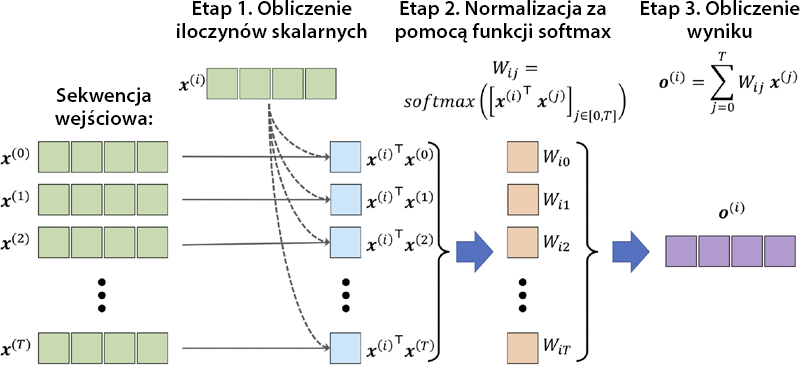

In [6]:
Image(filename='rysunki/16_15.png', width=700)

### Parametryzowanie mechanizmu samouwagi za pomocą wag kwerendy, klucza i wartości



## Wieloblokowy mechanizm uwagi i komórka transformatora

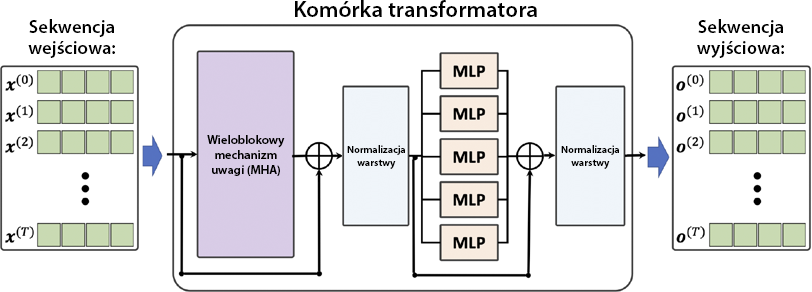

In [7]:
Image(filename='rysunki/16_16.png', width=700)


...


# Podsumowanie

...




Czytelnicy mogą zignorować poniższą komórkę.


In [24]:
! python ../.convert_notebook_to_script.py --input r16_cz2.ipynb --output r16_cz2.py

[NbConvertApp] Converting notebook ch16_part2.ipynb to script
[NbConvertApp] Writing 6935 bytes to ch16_part2.py
